# Forecasting with Small Time Series Data

This notebook explores how to forecast the next value in a small quarterly time series 
of electricity usage using ARIMA and SARIMA models, and how to derive 95% prediction intervals.

## Step 1: Simulate Quarterly Electricity Usage
Create a synthetic time series with a trend, seasonality, and random noise.


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
n = 25
seasonality = np.tile([5, 0, -3, 2], reps=7)[:n]  # seasonal pattern
noise = np.random.normal(0, 5, n)
trend = np.linspace(100, 130, n)
usage = trend + seasonality + noise

quarters = pd.date_range(start='2018-01-01', periods=n, freq='Q')
df = pd.DataFrame({'Quarter': quarters, 'Usage_kWh': usage})
df.set_index('Quarter', inplace=True)
df = df.asfreq('Q')




## Step 2: Visualize the Time Series


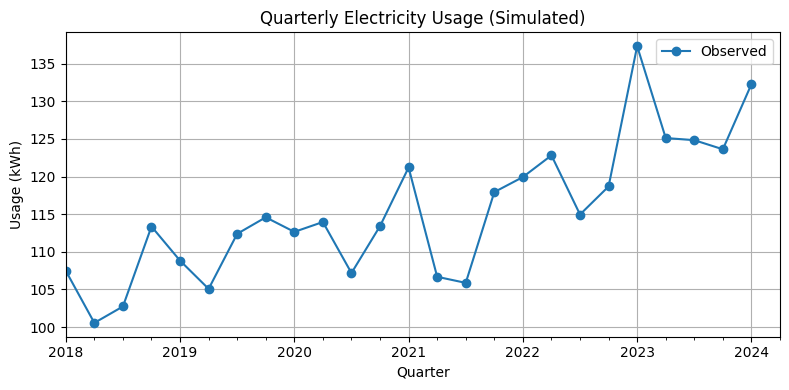

In [12]:
def plot_series(series, forecast=None, conf_int=None, title="Time Series", ylabel="Value"):
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Plot observed data
    series.plot(ax=ax, label='Observed', marker='o')

    # Extend x-axis to show forecast clearly
    if forecast is not None:
        forecast.plot(ax=ax, style='r*', label='Forecast')
        last_date = max(series.index.max(), forecast.index.max())
    else:
        last_date = series.index.max()

    # Optional: Add prediction intervals
    if conf_int is not None:
        ax.fill_between(conf_int.index,
                        conf_int.iloc[:, 0],
                        conf_int.iloc[:, 1],
                        color='pink', alpha=0.3, label='95% Prediction Interval')
        last_date = max(last_date, conf_int.index.max())

    # Extend x-axis limit by one more quarter for visual padding
    extended_xlim = [series.index.min(), last_date + pd.DateOffset(months=3)]
    ax.set_xlim(extended_xlim)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example usage
plot_series(df['Usage_kWh'], title='Quarterly Electricity Usage (Simulated)', ylabel='Usage (kWh)')




## Step 3: ARIMA Baseline Model
Fit a simple ARIMA(1,0,0) model without seasonal terms and produce a 1-step-ahead forecast.


In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
arima_model = ARIMA(df['Usage_kWh'], order=(1, 0, 0))
arima_results = arima_model.fit()

# Forecast next step
forecast = arima_results.get_forecast(steps=1)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)

# Print forecast value and 95% prediction interval
print(f"ARIMA Forecast for next quarter: {pred_mean.values[0]:.2f} kWh")
print(f"95% Prediction Interval: [{conf_int.iloc[0, 0]:.2f}, {conf_int.iloc[0, 1]:.2f}] kWh")


ARIMA Forecast for next quarter: 126.40 kWh
95% Prediction Interval: [112.53, 140.27] kWh






## Step 4: Fit a SARIMA Model
Fit a SARIMA(1,1,1)(1,1,1,4) model to account for seasonality and trend.


SARIMA Forecast for next quarter: 130.60 kWh
95% Prediction Interval: [118.70, 142.50] kWh


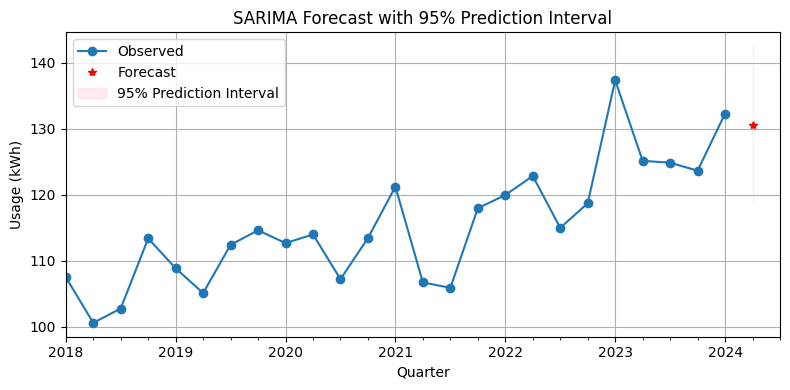

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(df['Usage_kWh'],
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 4),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_results = sarima_model.fit()

forecast = sarima_results.get_forecast(steps=1)
pred = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)

print(f"SARIMA Forecast for next quarter: {pred.values[0]:.2f} kWh")
print(f"95% Prediction Interval: [{conf_int.iloc[0, 0]:.2f}, {conf_int.iloc[0, 1]:.2f}] kWh")

plot_series(df['Usage_kWh'], forecast=pred, conf_int=conf_int,
            title='SARIMA Forecast with 95% Prediction Interval', ylabel='Usage (kWh)')






## Step 5: Auto-select SARIMA Parameters with AIC Minimization
Use `pmdarima.auto_arima` to select optimal (p,d,q)(P,D,Q,s) based on AIC.


In [15]:
import pmdarima as pm

auto_model = pm.auto_arima(df['Usage_kWh'],
                           seasonal=True, m=4,
                           stepwise=True,
                           suppress_warnings=True,
                           trace=True)

print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=141.794, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=139.705, Time=0.05 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=138.817, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=146.337, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[4] intercept   : AIC=143.336, Time=0.02 sec
 ARIMA(0,0,1)(1,1,1)[4] intercept   : AIC=140.816, Time=0.16 sec
 ARIMA(0,0,1)(0,1,2)[4] intercept   : AIC=140.816, Time=0.07 sec
 ARIMA(0,0,1)(1,1,0)[4] intercept   : AIC=139.697, Time=0.04 sec
 ARIMA(0,0,1)(1,1,2)[4] intercept   : AIC=142.816, Time=0.09 sec
 ARIMA(0,0,0)(0,1,1)[4] intercept   : AIC=136.817, Time=0.05 sec
 ARIMA(0,0,0)(1,1,1)[4] intercept   : AIC=138.817, Time=0.10 sec
 ARIMA(0,0,0)(0,1,2)[4] intercept   : AIC=138.817, Time=0.05 sec
 ARIMA(0,0,0)(1,1,0)[4] intercept   : AIC=138.030, Time=0.05 sec
 ARIMA(0,0,0)(1,1,2)[4] intercept   : AIC=140.817, 



## Step 6: Forecast Using the Optimized Model
Refit the best SARIMA model using `statsmodels` for advanced diagnostics and intervals.


Optimized Forecast: 124.68 kWh
95% Prediction Interval: [108.89, 140.47] kWh


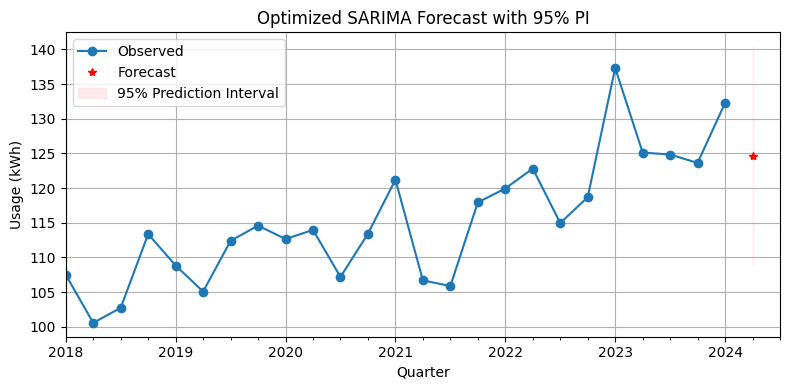

In [16]:
optimized_model = SARIMAX(df['Usage_kWh'],
                          order=auto_model.order,
                          seasonal_order=auto_model.seasonal_order,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
optimized_results = optimized_model.fit()

forecast = optimized_results.get_forecast(steps=1)
pred = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)

print(f"Optimized Forecast: {pred.values[0]:.2f} kWh")
print(f"95% Prediction Interval: [{conf_int.iloc[0, 0]:.2f}, {conf_int.iloc[0, 1]:.2f}] kWh")

plot_series(df['Usage_kWh'], forecast=pred, conf_int=conf_int,
            title='Optimized SARIMA Forecast with 95% PI', ylabel='Usage (kWh)')
